# 3. DataFrame
- 행,열로 구조화도니 데이터 구조, RDD인데 schema 얹어 놓은 것
- spark 1.0 당시 schemaRDD라는 명칭으로 제공 됨
- 대용량 데이터를 처리하기 위해 만들어진 프레임워크로 분산해서 사용할 수 있게 고안 됨
- 모델 schema를 설정해서 사용함
- '열(row)'에 대해 명칭 및 '데이터 type'을 갖고 있고, 이를 지켜서 데이터 저장함

**Schema**
- row는 dataframe의 행
- python의 list, dict를 사용해서 row 구성할 수 있음
- column은 dataframe의 열


**dataframe의 데이터 type**
- NullType
- StringType
- BinaryType
- BooleanType
- DateType
- TimestampType
- DoubleType
- DecimalType
- ShortType
- ArrayType
- MapType

## 3.2 DataFrame API 사용하기

### 3.2.0 DataFrame 생성하기

In [18]:
%%writefile data/name_height_weight.txt
Kim 180.0 78.0
Park 190.0 86.0
Lee 189.5 89.5
Yang 195.0 94.0
Oh 200.0 104.0

Overwriting data/name_height_weight.txt


In [19]:
# dataframe 생성하기
df = (spark
.read
.options(header='false',inferschema='true', delimiter=' ')
.csv(os.path.join('data/name_height_weight.txt'))
     )

In [20]:
# dataframe schema 프린트
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)



In [21]:
# dataframe 보여주기
df.show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
| Kim|180.0| 78.0|
|Park|190.0| 86.0|
| Lee|189.5| 89.5|
|Yang|195.0| 94.0|
|  Oh|200.0|104.0|
+----+-----+-----+



In [22]:
# dataframe column 확인
df.columns

['_c0', '_c1', '_c2']

### 3.2.1 Column 추가  - withColumn()

In [23]:
# 기존 있던 column 보기 좋게 바꿔주고 원하는 형으로 변환
df = df.withColumn("name", df._c0.cast("string"))
df = df.withColumn("height", df['_c1'].cast("double"))
df = df.withColumn("weight", df['_c2'].cast("double"))

In [24]:
# dataframe schema 프린트
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- name: string (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



### 3.2.2. Column 삭제 - drop()

In [25]:
# 필요없는 column 삭제
df = df.drop('_c0').drop('_c1').drop('_c2')

In [26]:
# dataframe schema 프린트
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



### 3.2.3 where(행 선택), select(열 선택)

In [27]:
# dataframe 보여주기
df.show()

+----+------+------+
|name|height|weight|
+----+------+------+
| Kim| 180.0|  78.0|
|Park| 190.0|  86.0|
| Lee| 189.5|  89.5|
|Yang| 195.0|  94.0|
|  Oh| 200.0| 104.0|
+----+------+------+



In [33]:
# 키 190 이상인 사람들 행(row) 선택
df.where(df.height >= 190).show()

+----+------+------+
|name|height|weight|
+----+------+------+
|Park| 190.0|  86.0|
|Yang| 195.0|  94.0|
|  Oh| 200.0| 104.0|
+----+------+------+



In [66]:
# 키 190 이상인 사람들 행 선택, 그리고 name, height column만 출력
df.where(df.height >= 190).select(df.name,df.height).show()

+----+------+
|name|height|
+----+------+
|Park| 190.0|
|Yang| 195.0|
|  Oh| 200.0|
+----+------+



In [34]:
# 키 190 이상이면서, 몸무게 90 이상인 사람들 행 선택
df.where(df.height >= 190).where(df.weight >= 90).show()

+----+------+------+
|name|height|weight|
+----+------+------+
|Yang| 195.0|  94.0|
|  Oh| 200.0| 104.0|
+----+------+------+



In [68]:
# 키 190 이상이면서, 몸무게 90 이상인 사람들 행 선택, 그리고 name, height column만 출력
df.where(df.height >= 190).where(df.weight >= 90).select(df.name,df.height).show()

+----+------+
|name|height|
+----+------+
|Yang| 195.0|
|  Oh| 200.0|
+----+------+



## 3.3 Join
- inner join : 왼쪽과 오른쪽 데이터셋에 키가 있는 로우를 유지
- outer join : 왼쪽이나 오른쪽 데이터셋에 키가 있는 로우를 유지
- left outer join : 왼쪽 데이터셋에 키가 있는 로우를 유지
- right outher join : 오른쪽 데이터셋에 키가 있는 로우를 유지
- left semi join : 왼쪽 데이터셋의 키가 오른쪽 데이터셋에 있는 경우에는 키가 일치하는 왼쪽 데이터셋만 유지 
- left anti join : 왼쪽 데이터셋의 키가 오른쪽 테이터셋에 없는 경우에는 키가 일치하지 않는 왼쪽 데이터셋만 유지
- cross join 또는 cartesian join : 왼쪽 데이터셋의 모든 로우와 오른쪽 데이터셋의 모든 로우를 조합

### 3.3.0 데이터 생성

In [11]:
# 예제 위한 데이터셋 생성
person = spark.createDataFrame([
    (0, "Bill Chambers",0,[100]),
    (1, "Matei Zaharia",1,[500,250,100]),
    (2, "Michael Armbrust",1,[250,100])
]).toDF("id","name","graduate_program","spark_status")

graduateProgram = spark.createDataFrame([
    (0,"Masters","School of Information","UC Berkeley"),
    (2,"Masters","EECS","UC Berkeley"),
    (1,"Ph.D","EECS","UC Berkeley")
]).toDF("id","degree","department","school")

sparkStatus = spark.createDataFrame([
    (500,"Vice President"),
    (250,"PMC Member"),
    (100,"Contributor")
]).toDF("id","status")

In [12]:
# 데이터셋 테이블로 등록
person.createOrReplaceTempView("person")
graduateProgram.createOrReplaceTempView("graduateProgram")
sparkStatus.createOrReplaceTempView("sparkStatus")

### 3.3.1 inner join(내부 조인)
- inner join은 DataFrame이나 테이블에 존재하는 키를 평가
- true로 평가되는 로우만 결합

In [13]:
# graduateProgram과 person 조인해서 새로운 DF 만드는 예제
joinExpression = person["graduate_program"] == graduateProgram["id"]

In [14]:
person.join(graduateProgram, joinExpression).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [15]:
# .join() 의 세번쨰 파라미터로 joinType 지정 가능
joinType = "inner"
person.join(graduateProgram, joinExpression, joinType).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



### 3.3.2 outer join(외부 조인)
- outer join은 DataFrame이나 테이블에 존제하는 키를 평가
- true 나 false로 평가되는 로우 포함
- DF에 일치하는 로우 없으면 null 자동 삽입

In [16]:
joinType = "outer"
joinExpression = person["graduate_program"] == graduateProgram["id"]
person.join(graduateProgram, joinExpression, joinType).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|null|            null|            null|           null|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [18]:
joinType = "outer"
joinExpression = person["graduate_program"] == graduateProgram["id"]
graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
| id| degree|          department|     school|  id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|   0|   Bill Chambers|               0|          [100]|
|  1|   Ph.D|                EECS|UC Berkeley|   1|   Matei Zaharia|               1|[500, 250, 100]|
|  1|   Ph.D|                EECS|UC Berkeley|   2|Michael Armbrust|               1|     [250, 100]|
|  2|Masters|                EECS|UC Berkeley|null|            null|            null|           null|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+



### 3.3.3 left outer join (왼쪽 외부 조인)
- left outer join은 DataFrame이나 테이블에 존재하는 키 평가
- 왼쪽 DF의 모든 로우와 왼쪽 DF와 일치하는 오른쪽 DF의 로우를 함께 포함
- 오른쪽 DF에 일치하는 로우 없을 시, 해당 위치 null 삽입

In [17]:
joinType = "left_outer"
joinExpression = person["graduate_program"] == graduateProgram["id"]
graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
| id| degree|          department|     school|  id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|   0|   Bill Chambers|               0|          [100]|
|  1|   Ph.D|                EECS|UC Berkeley|   1|   Matei Zaharia|               1|[500, 250, 100]|
|  1|   Ph.D|                EECS|UC Berkeley|   2|Michael Armbrust|               1|     [250, 100]|
|  2|Masters|                EECS|UC Berkeley|null|            null|            null|           null|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+



### 3.3.4 right outer join(오른쪽 외부 조인)
- right outer join은 DataFrame이나 테이블에 존재하는 키 평가
- 오른쪽 DF의 모든 로우와 오른쪽 DF와 일치하는 왼쪽 DF의 로우를 함께 포함
- 왼쪽 DF에 일치하는 로우가 없을 시, 해당 위치 null 삽입

In [19]:
joinType = "right_outer"
joinExpression = person["graduate_program"] == graduateProgram["id"]
person.join(graduateProgram, joinExpression, joinType).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|null|            null|            null|           null|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



### 3.3.5 left semi join(왼쪽 세미 조인)
- left semi join은 오른쪽 DF의 어떤 값도 포함하지 않기 때문에 다른 조인과 약간 다름
- 2번째 DF는 값이 존재하는지 확인하기 위해 값만 비교하는 용도로 사용
- 만약 값이 존재하면 왼쪽 DF에 중복 키가 존재하더라도 해당 로우는 결과에 포함
- 기존의 조인 기능과 달리 DF의 필터 정도라 볼 수 있음

In [20]:
joinType = "left_semi"
joinExpression = person["graduate_program"] == graduateProgram["id"]
graduateProgram.join(person,joinExpression,joinType).show()

+---+-------+--------------------+-----------+
| id| degree|          department|     school|
+---+-------+--------------------+-----------+
|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Ph.D|                EECS|UC Berkeley|
+---+-------+--------------------+-----------+



### 3.3.6 left anti join(왼쪽 안티 조인)
- left semi join과 반대 개념
- 오른쪽 DF의 어떤 값도 포함하지 않음
- 2번째 DF는 값이 존재하는지 확인하기 위해 값만 비교하는 용도로 사용
- but, 2번째 DF에 존재하는 값을 유지하는 대신 2번째 DF에서 관련된 키를 찾을 수 없는 로우만 결과에 포함
- SQL의 NOT-IN 스타일 필터라 볼 수 있음

In [21]:
joinType = "left_anti"
joinExpression = person["graduate_program"] == graduateProgram["id"]
graduateProgram.join(person,joinExpression,joinType).show()

+---+-------+----------+-----------+
| id| degree|department|     school|
+---+-------+----------+-----------+
|  2|Masters|      EECS|UC Berkeley|
+---+-------+----------+-----------+



### 3.3.7 cartesian join(cross join, 크로스 조인, 카테시안 조인)
- 조건절을 기술하지 않은 inner join
- cartesian join은 왼쪽 DF의 모든 로우를 오른쪽 DF의 모든 로우와 결합

In [22]:
person.crossJoin(graduateProgram).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  0|   Bill Chambers|               0|          [100]|  2|Masters|                EECS|UC Berkeley|
|  0|   Bill Chambers|               0|          [100]|  1|   Ph.D|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  2|Masters|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|   Ph.D|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  0|Masters|School of Informa...|UC 

## 3.4 User Defined Function(udf) - 사용자 정의 함수

## 3.5 Dataframe bicycle 예제
- 문제1 : 년도별 대여건수 합계
- 문제2 : 년도별, 월별 대여건수 합계, 그래프
- 문제4 : 년도별, 분기별 대여건수 합계, 그래프

In [48]:
from datetime import datetime
from pyspark.sql.functions import col, udf, desc
from pyspark.sql.types import DateType
import pyspark.sql.functions as F

### 3.4.0 데이터 읽기

In [36]:
bicycle = spark.read.format('com.databricks.spark.csv')\
.options(header='true', inferschema='true').load('data/bicycle.csv')

In [37]:
bicycle.take(3)

[Row(date='2018.1.1', count=4950),
 Row(date='2018.1.2', count=7136),
 Row(date='2018.1.3', count=7156)]

In [39]:
bicycle.show(5)

+--------+-----+
|    date|count|
+--------+-----+
|2018.1.1| 4950|
|2018.1.2| 7136|
|2018.1.3| 7156|
|2018.1.4| 7102|
|2018.1.5| 7705|
+--------+-----+
only showing top 5 rows



In [40]:
bicycle.printSchema()

root
 |-- date: string (nullable = true)
 |-- count: integer (nullable = true)



### 3.4.1 date 형 변환 해주기(string -> datatype)

In [41]:
# 사용자 정의 함수 udf(User Defined Function) 생성
toDate = udf(lambda x:datetime.strptime(x, '%Y.%m.%d'),DateType())

In [42]:
# column 'date'를 새로운 column 'Date' datetype로 변환해서 생성하고, column 'date' 삭제하기
bicycle = bicycle.withColumn('Date',toDate(bicycle['date'])).drop(bicycle['date'])

In [43]:
# column 'count'를 새로운 column 'Count' integertype으로 변환해서 생성하고, column 'count' 삭제하기
bicycle = bicycle.withColumn('Count',bicycle['count'].cast("integer")).drop(bicycle['count'])

In [45]:
bicycle.show(5)

+----------+-----+
|      Date|Count|
+----------+-----+
|2018-01-01| 4950|
|2018-01-02| 7136|
|2018-01-03| 7156|
|2018-01-04| 7102|
|2018-01-05| 7705|
+----------+-----+
only showing top 5 rows



In [44]:
bicycle.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Count: integer (nullable = true)



### 문제 1 : 년도별 대여건수 합계

In [51]:
# 년도, 분기 ,월 column 생성해주기
bicycle = (bicycle
.withColumn('year', F.year('date'))
.withColumn('quarter', F.quarter('date'))
.withColumn('month', F.month('date'))
          )

In [52]:
bicycle.show(5)

+----------+-----+----+-------+-----+
|      Date|Count|year|quarter|month|
+----------+-----+----+-------+-----+
|2018-01-01| 4950|2018|      1|    1|
|2018-01-02| 7136|2018|      1|    1|
|2018-01-03| 7156|2018|      1|    1|
|2018-01-04| 7102|2018|      1|    1|
|2018-01-05| 7705|2018|      1|    1|
+----------+-----+----+-------+-----+
only showing top 5 rows



In [53]:
bicycle.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Count: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- month: integer (nullable = true)



In [62]:
bicycle.groupBy('year').count().show()

+----+-----+
|year|count|
+----+-----+
|2018|  365|
|2019|  364|
|2020|  182|
+----+-----+



In [63]:
Q1 = bicycle.groupBy('year').agg({"count":"sum"})

In [64]:
Q1.show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|  19071949|
|2020|  10498549|
+----+----------+



### 문제2 : 년도별, 월별 대여건수 합계, 그래프

In [59]:
bicycle.show(5)

+----------+-----+----+-------+-----+
|      Date|Count|year|quarter|month|
+----------+-----+----+-------+-----+
|2018-01-01| 4950|2018|      1|    1|
|2018-01-02| 7136|2018|      1|    1|
|2018-01-03| 7156|2018|      1|    1|
|2018-01-04| 7102|2018|      1|    1|
|2018-01-05| 7705|2018|      1|    1|
+----------+-----+----+-------+-----+
only showing top 5 rows



In [71]:
Q2 = bicycle.groupBy('year').pivot('month').agg({"Count":"sum"})

In [72]:
Q2.show()

+----+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
|year|     1|     2|      3|      4|      5|      6|      7|      8|      9|     10|     11|    12|
+----+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
|2018|164367|168741| 462661| 687885| 965609|1207123|1100015|1037505|1447993|1420621| 961532|500822|
|2019|495573|471543| 904819|1468000|2232895|2293879|2164086|2101184|2084222|2436401|1537269|882078|
|2020|794162|762274|1533535|2157390|2480330|2770858|   null|   null|   null|   null|   null|  null|
+----+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+



In [76]:
pd = Q2.toPandas()

In [77]:
pd

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2018,164367,168741,462661,687885,965609,1207123,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
1,2019,495573,471543,904819,1468000,2232895,2293879,2164086.0,2101184.0,2084222.0,2436401.0,1537269.0,882078.0
2,2020,794162,762274,1533535,2157390,2480330,2770858,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
Q2_pd = pd.drop('year',1).transpose()

In [79]:
Q2_pd

,0,1,2
1,164367.0,495573.0,794162.0
2,168741.0,471543.0,762274.0
3,462661.0,904819.0,1533535.0
4,687885.0,1468000.0,2157390.0
5,965609.0,2232895.0,2480330.0
6,1207123.0,2293879.0,2770858.0
7,1100015.0,2164086.0,NaN
8,1037505.0,2101184.0,NaN
9,1447993.0,2084222.0,NaN
10,1420621.0,2436401.0,NaN


In [80]:
Q2_pd.columns=[2018,2019,2020]

<AxesSubplot:>

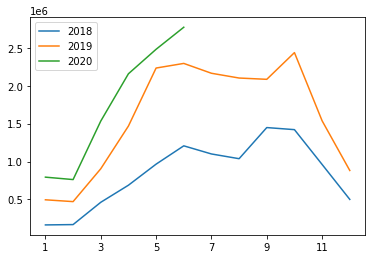

In [81]:
Q2_pd.plot(kind='line')

### 문제3 : 년도별, 분기별 대여건수 합계, 그래프

In [69]:
bicycle.show(5)

+----------+-----+----+-------+-----+
|      Date|Count|year|quarter|month|
+----------+-----+----+-------+-----+
|2018-01-01| 4950|2018|      1|    1|
|2018-01-02| 7136|2018|      1|    1|
|2018-01-03| 7156|2018|      1|    1|
|2018-01-04| 7102|2018|      1|    1|
|2018-01-05| 7705|2018|      1|    1|
+----------+-----+----+-------+-----+
only showing top 5 rows



In [73]:
Q3 = bicycle.groupBy('year').pivot('quarter').agg({"Count":"sum"})

In [74]:
Q3.show()

+----+-------+-------+-------+-------+
|year|      1|      2|      3|      4|
+----+-------+-------+-------+-------+
|2018| 795769|2860617|3585513|2882975|
|2019|1871935|5994774|6349492|4855748|
|2020|3089971|7408578|   null|   null|
+----+-------+-------+-------+-------+



In [82]:
pd = Q3.toPandas()

In [83]:
pd

,year,1,2,3,4
0,2018,795769,2860617,3585513.0,2882975.0
1,2019,1871935,5994774,6349492.0,4855748.0
2,2020,3089971,7408578,NaN,NaN


In [84]:
Q3_pd = pd.drop('year',1).transpose()

In [85]:
Q3_pd

,0,1,2
1,795769.0,1871935.0,3089971.0
2,2860617.0,5994774.0,7408578.0
3,3585513.0,6349492.0,NaN
4,2882975.0,4855748.0,NaN


In [86]:
Q3_pd.columns=[2018,2019,2020]

<AxesSubplot:>

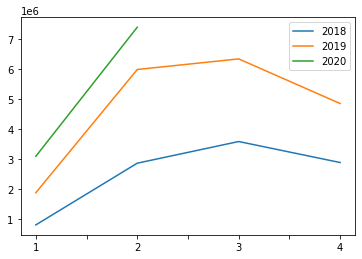

In [87]:
Q3_pd.plot(kind='line')